In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import JLD
using Colors
import FileIO
import PyPlot

In [2]:
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end


function db_scale_img_diff(img1,img2 , min , max)
    log_img = 10*log10.(img1).-10*log10.(img2)
    log_img = (log_img.-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

function scale_img(img , min , max)
    scale_img = (img.-min)./(max-min)
    scale_img[scale_img.>1] .= 0.999
    scale_img[scale_img.<0] .= 0.001
    return scale_img
end


function scale_img(img)
    min = minimum(reshape(img,:))
    max = maximum(reshape(img,:))
    return scale_img(img , min , max)
end

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

flat(band,test_area) = reshape(band[test_area...],:)

function scale_xticks(fig,ax,factor)
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [replace(item, '−' => '-') for item in labels]
    labels = [parse(Float64,item) for item in labels]
    labels = labels.*factor
    labels = [string(item) for item in labels]
    ax.set_xticklabels(labels)
end

function pretty_img(bands,min,max,k=1/1.4)
    pre = db_scale_img((bands[2] .+bands[3])./2,min,max) 
    co = db_scale_img(bands[1],min,max) 
    co = co.^k
    pre = pre.^k
    return Colors.RGB{Float32}.(pre,co,co);
end



function grid_images(img_array,pad =2)
    
    v_pad = zeros(RGB{Float32},pad,size(img_array[1,1])[2])
    grid_img = [vcat(elem,v_pad) for elem in img_array]
    
    grid_img = [vcat(grid_img[:,i]...) for i in 1:size(img_array)[2]]
    
    h_pad = zeros(RGB{Float32},size(grid_img[1])[1],pad)
    grid_img = [hcat(elem,h_pad) for elem in grid_img]
    
    grid_img = hcat(grid_img...)

    return grid_img[1:end-pad,1:end-pad]
end


grid_images (generic function with 2 methods)

## Vejle

In [3]:
folder = "/home/data/simon/processed/66_fyn_winter2020/vejle" # desend

dem_nan = 40

co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")[:,end:-1:1]
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")[:,end:-1:1]

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data")[:,end:-1:1] for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data")[:,end:-1:1] for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data")[:,end:-1:1].-dem_nan;

In [4]:
folder = "/home/data/simon/processed/177_jutlandS_winter2020/ribe" 

dem_nan = 40
co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")[end:-1:1,:]
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")[end:-1:1,:]

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data")[end:-1:1,:] for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data")[end:-1:1,:] for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data")[end:-1:1,:].-dem_nan;

In [5]:
#### 

VV_org = deepcopy(VV)
VH_org = deepcopy(VH)

filt = SlcUtil.temporal_filter([VV[1],VH[1]],5);

VV = SlcUtil.temporal_filter(VV,5);
VH = SlcUtil.temporal_filter(VH,5);

VV[1] = filt[1]
VH[1] = filt[2];

## Test_area

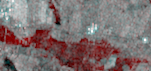

In [235]:
#test_area = (220:240,80:140) ; folder = "/home/data/simon/result/explore/area_1"
#test_area = (220:270,80:160) ; folder = "/home/data/simon/result/explore/area_2"
#test_area = (350:380,250:400) ; folder = "/home/data/simon/result/explore/area_3"
#test_area = (300:500,750:950) ; folder = "/home/data/simon/result/explore_ribe/area_1"
test_area = (550:620,1050:1200) ; folder = "/home/data/simon/result/explore_ribe/area_2"
pretty_img(VV,min_vv,max_vv)[test_area...]

In [236]:
img = pretty_img(VV,min_vv,max_vv)[test_area...];
img_path = joinpath(folder,"pretty_VV.png")
FileIO.save(img_path,img);

img = pretty_img(VH,min_vh,max_vh)[test_area...];
img_path = joinpath(folder,"pretty_VH.png")
FileIO.save(img_path,img);

img = Colors.RGB{Float32}.(abs.(pre_gamma),abs.(co_gamma),abs.(co_gamma));
img_path = joinpath(folder,"PreCoCo_coherence.png")
FileIO.save(img_path,img[test_area...]);

### Filter together?

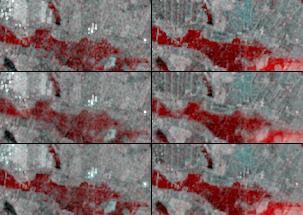

In [237]:
col1 = [VV_org,SlcUtil.temporal_filter(VV_org,5),VV]
col1 = [pretty_img(elem,min_vv,max_vv)[test_area...] for elem in col1]
col2 = [VH_org,SlcUtil.temporal_filter(VH_org,5),VH]
col2 = [pretty_img(elem,min_vh,max_vh)[test_area...] for elem in col2]
img = grid_images(hcat(col1,col2),1)

img_path = joinpath(folder,"Filter_test.png")
FileIO.save(img_path,img);
img

## Histograms

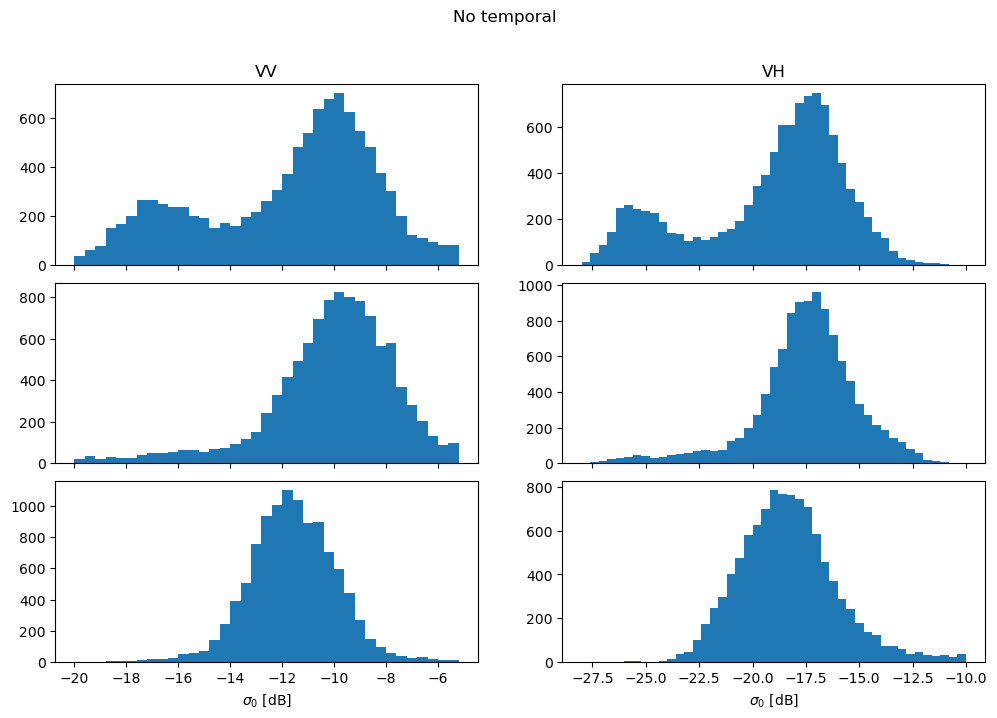

In [238]:
band1 = [10 .*log10.(elem) for elem in VV]
band2 = [10 .*log10.(elem) for elem in VH]
bins1 = -20:0.4:-5
bins2 = -28:0.4:-10

fig, axs = PyPlot.subplots(3, 2, sharex="col",
                        gridspec_kw=Dict("hspace"=>0.1))
fig.suptitle("No temporal")
fig.set_size_inches(12,7.5)

axs[1,1].hist(flat(band1[1],test_area),bins=bins1);
axs[1,1].set_title("VV")
axs[2,1].hist(flat(band1[2],test_area),bins=bins1);
axs[3,1].hist(flat(band1[3],test_area),bins=bins1);
axs[3,1].set(xlabel="\$\\sigma_0\$ [dB]");

axs[1,2].hist(flat(band2[1],test_area),bins=bins2);
axs[1,2].set_title("VH")
axs[2,2].hist(flat(band2[2],test_area),bins=bins2);
axs[3,2].hist(flat(band2[3],test_area),bins=bins2);
axs[3,2].set(xlabel="\$\\sigma_0 \$ [dB]");

fig_path = joinpath(folder,"hist_area1_dB_org.png")

fig.savefig(fig_path, dpi=100)

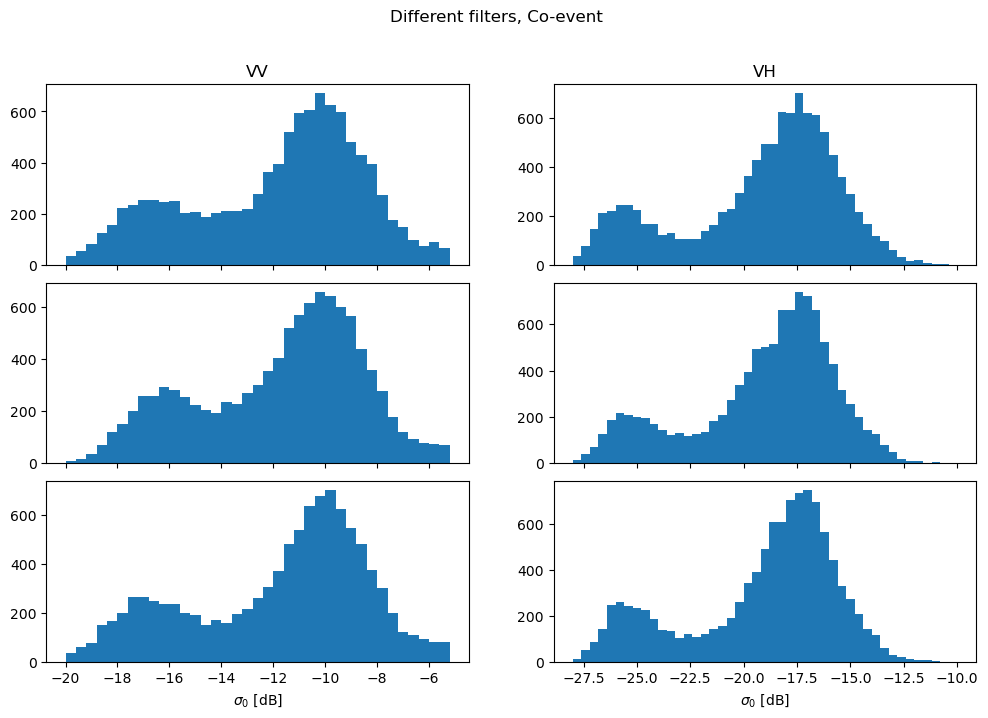

In [239]:
band1 = deepcopy(VV_org)
band2 = deepcopy(VH_org)

band1[2] = SlcUtil.temporal_filter(VV_org,5)[1]
band2[2] = SlcUtil.temporal_filter(VH_org,5)[1]
band1[3] = VV[1]
band2[3] = VH[1]

band1 = [10 .*log10.(elem) for elem in band1]
band2 = [10 .*log10.(elem) for elem in band2]

bins1 = -20:0.4:-5
bins2 = -28:0.4:-10

fig, axs = PyPlot.subplots(3, 2, sharex="col",
                        gridspec_kw=Dict("hspace"=>0.1))
fig.suptitle("Different filters, Co-event")
fig.set_size_inches(12,7.5)

axs[1,1].hist(flat(band1[1],test_area),bins=bins1);
axs[1,1].set_title("VV")
axs[2,1].hist(flat(band1[2],test_area),bins=bins1);
axs[3,1].hist(flat(band1[3],test_area),bins=bins1);
axs[3,1].set(xlabel="\$\\sigma_0\$ [dB]");

axs[1,2].hist(flat(band2[1],test_area),bins=bins2);
axs[1,2].set_title("VH")
axs[2,2].hist(flat(band2[2],test_area),bins=bins2);
axs[3,2].hist(flat(band2[3],test_area),bins=bins2);
axs[3,2].set(xlabel="\$\\sigma_0 \$ [dB]");

fig_path = joinpath(folder,"hist_filt_non_temp_pol_dB.png")

fig.savefig(fig_path, dpi=100)

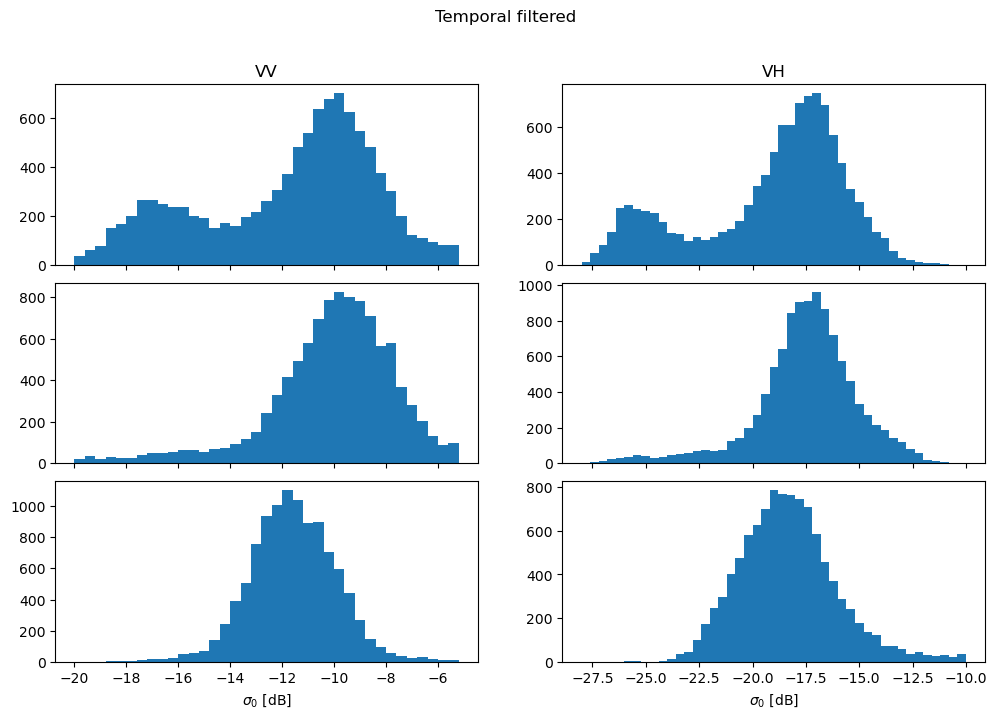

In [240]:
band1 = [10 .*log10.(elem) for elem in VV]
band2 = [10 .*log10.(elem) for elem in VH]
bins1 = -20:0.4:-5
bins2 = -28:0.4:-10

fig, axs = PyPlot.subplots(3, 2, sharex="col",
                        gridspec_kw=Dict("hspace"=>0.1))
fig.suptitle("Temporal filtered")
fig.set_size_inches(12,7.5)

axs[1,1].hist(flat(band1[1],test_area),bins=bins1);
axs[1,1].set_title("VV")
axs[2,1].hist(flat(band1[2],test_area),bins=bins1);
axs[3,1].hist(flat(band1[3],test_area),bins=bins1);
axs[3,1].set(xlabel="\$\\sigma_0\$ [dB]");

axs[1,2].hist(flat(band2[1],test_area),bins=bins2);
axs[1,2].set_title("VH")
axs[2,2].hist(flat(band2[2],test_area),bins=bins2);
axs[3,2].hist(flat(band2[3],test_area),bins=bins2);
axs[3,2].set(xlabel="\$\\sigma_0 \$ [dB]");

fig_path = joinpath(folder,"hist_area1_dB_filt.png")

fig.savefig(fig_path, dpi=100)

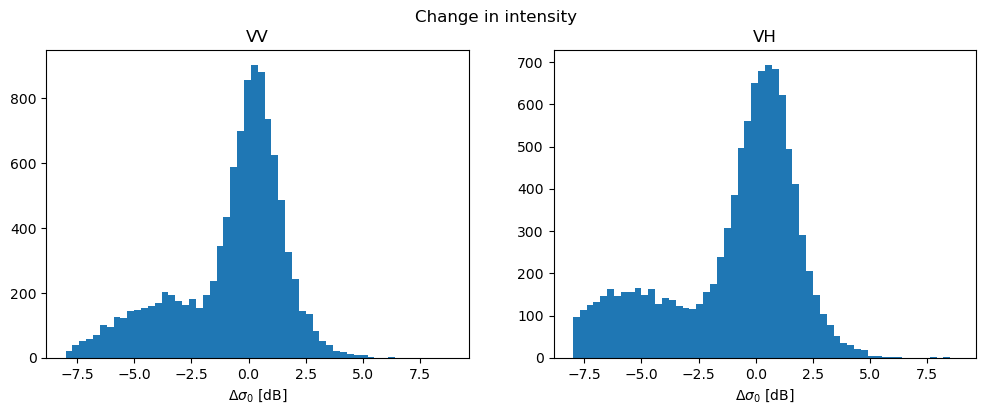

In [241]:
diff_VV = 10*log10.(VV[1]) .- (10*log10.(VV[2]) .+ 10*log10.(VV[3]))./2
diff_VH = 10*log10.(VH[1]) .- (10*log10.(VH[2]) .+ 10*log10.(VH[3]))./2
bins1 = -8:0.3:9
bins2 = -8:0.3:9

fig, axs = PyPlot.subplots(1, 2)
fig.suptitle("Change in intensity")
fig.set_size_inches(12,4)

axs[1].hist(flat(diff_VV,test_area),bins=bins1);
axs[1].set_title("VV")
axs[1].set(xlabel="\$ \\Delta \\sigma_0\$ [dB]");

axs[2].hist(flat(diff_VH ,test_area),bins=bins2);
axs[2].set_title("VH")
axs[2].set(xlabel="\$ \\Delta \\sigma_0 \$ [dB]");

fig_path = joinpath(folder,"hist_diff_dB_filt.png")

fig.savefig(fig_path, dpi=100)

### Scatter 

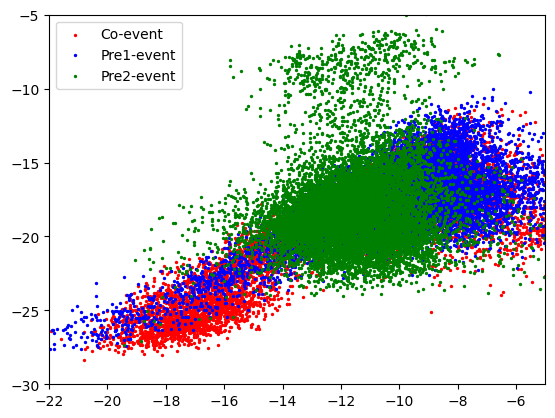

In [242]:
band1 = [10 .*log10.(elem) for elem in VV]
band2 = [10 .*log10.(elem) for elem in VH]
 fig = PyPlot.figure()
PyPlot.scatter(flat(band1[1],test_area),flat(band2[1],test_area),s=2,c="r");
PyPlot.scatter(flat(band1[2],test_area),flat(band2[2],test_area),s=2,c="b");
PyPlot.scatter(flat(band1[3],test_area),flat(band2[3],test_area),s=2,c="g");
PyPlot.xlim(-22,-5)
PyPlot.ylim(-30,-5)
 PyPlot.legend(["Co-event","Pre1-event","Pre2-event"])

fig_path = joinpath(folder,"scatter_dB_filt.png")

fig.savefig(fig_path, dpi=100)

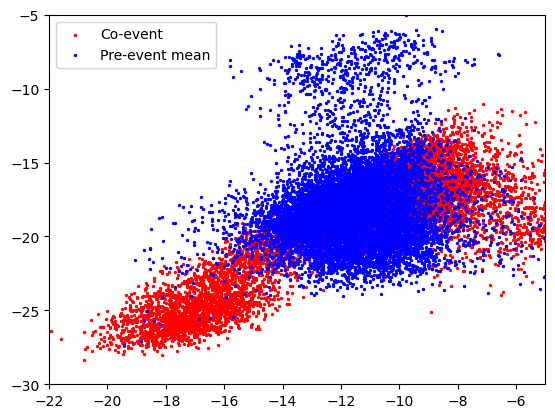

In [243]:
band1 = [10 .*log10.(VV[1]), 10 .*log10.((VV[3] .+ VV[3])./2) ]
band2 = [10 .*log10.(VH[1]), 10 .*log10.((VH[3] .+ VH[3])./2) ]

fig = PyPlot.figure()
PyPlot.scatter(flat(band1[1],test_area),flat(band2[1],test_area),s=2,c="r");
PyPlot.scatter(flat(band1[2],test_area),flat(band2[2],test_area),s=2,c="b");
PyPlot.xlim(-22,-5)
PyPlot.ylim(-30,-5)
 PyPlot.legend(["Co-event","Pre-event mean"])

fig_path = joinpath(folder,"scatter_dB_filt_mean.png")

fig.savefig(fig_path, dpi=100)

## Mask water 

### Co intensity

In [244]:
function add_mask(img,mask,color=(1,0,0))
    color = Colors.RGB{Float32}(color...)
    img_cop = copy(img)
    img_cop[mask] .= color
    return img_cop
end


add_mask (generic function with 2 methods)

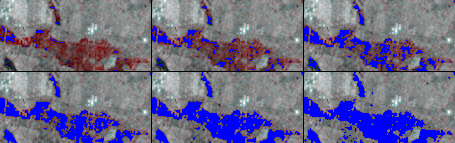

In [245]:
thresholds = [[-19 -18 -17]; [-16 -15 -14]]
mask_ar = [(10 .*log10.(VV[1][test_area...])).< t for t in thresholds];
img = pretty_img(VV,min_vv,max_vv)[test_area...]
img = grid_images([add_mask(img,mask,(0,0,1)) for mask in mask_ar],1)

img_path = joinpath(folder,"CO_VV_water_mask.png")
FileIO.save(img_path,img);
img

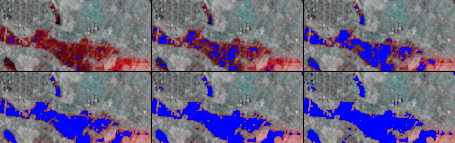

In [246]:
thresholds = [[-27 -26 -25]; [-24 -23 -22]]
mask_ar = [(10 .*log10.(VH[1][test_area...])).< t for t in thresholds];
img = pretty_img(VH,min_vh,max_vh)[test_area...]
img = grid_images([add_mask(img,mask,(0,0,1)) for mask in mask_ar],1)

img_path = joinpath(folder,"CO_VH_water_mask.png")
FileIO.save(img_path,img);
img

## Combined 

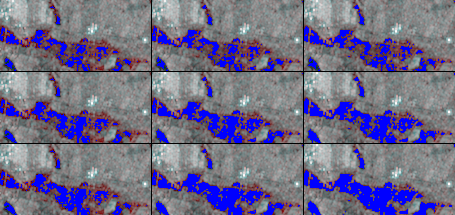

In [247]:
thresholds_vv = [-17,-16,-15]
thresholds_vh = [-25,-24,-23]
mask_ar = [((10 .*log10.(VH[1][test_area...])).< t_vh) .& ((10 .*log10.(VV[1][test_area...])).< t_vv) 
            for t_vv = thresholds_vv, t_vh=thresholds_vh];
img = pretty_img(VV,min_vv,max_vv)[test_area...]
img = grid_images([add_mask(img,mask,(0,0,1)) for mask in mask_ar],1)

img_path = joinpath(folder,"CO_VV_VH_water_mask.png")
FileIO.save(img_path,img);
img

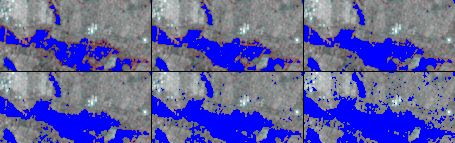

In [248]:
thresholds = [[-40 -38 -36]; [-34 -32 -30]]
mask_ar = [(10 .*log10.(VH[1][test_area...]) .+ 10 .*log10.(VV[1][test_area...])) .< t for t in thresholds];
img = pretty_img(VV,min_vv,max_vv)[test_area...]
img = grid_images([add_mask(img,mask,(0,0,1)) for mask in mask_ar],1)

img_path = joinpath(folder,"CO_VV_VH_water_mask_sum.png")
FileIO.save(img_path,img);
img

## Change 

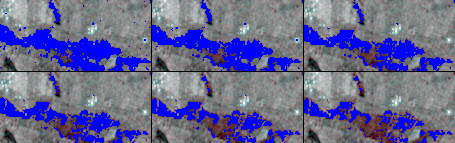

In [249]:

diff_VV = 10*log10.(VV[1]) .- (10*log10.(VV[2]) .+ 10*log10.(VV[3]))./2

thresholds = [[-2 -2.5 -3]; [-3.5 -4 -4.5]]
mask_ar = [diff_VV[test_area...] .< t for t in thresholds];
img = pretty_img(VV,min_vv,max_vv)[test_area...]
img = grid_images([add_mask(img,mask,(0,0,1)) for mask in mask_ar],1)

img_path = joinpath(folder,"difVV_water_mask.png")
FileIO.save(img_path,img);
img

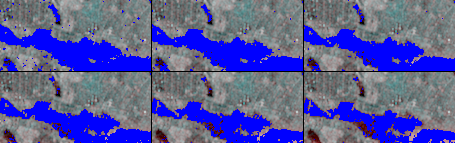

In [250]:

diff_VH = 10*log10.(VH[1]) .- (10*log10.(VH[2]) .+ 10*log10.(VH[3]))./2

thresholds = [[-2 -2.5 -3]; [-3.5 -4 -4.5]]
mask_ar = [diff_VH[test_area...] .< t for t in thresholds];
img = pretty_img(VH,min_vh,max_vh)[test_area...]
img = grid_images([add_mask(img,mask,(0,0,1)) for mask in mask_ar],1)

img_path = joinpath(folder,"difVH_water_mask.png")
FileIO.save(img_path,img);
img

## All image

In [230]:
mask = (10 .*log10.(VH[1]) .+ 10 .*log10.(VV[1])).< -40
img = pretty_img(VV,min_vv,max_vv)
img = add_mask(img,mask,(0,0,1))

img_path = joinpath("/home/data/simon/result/explore_ribe","water_co_VVVH40.png")
FileIO.save(img_path,img);

In [231]:
mask = ((10 .*log10.(VH[1])).< -24) .& ((10 .*log10.(VV[1])).< -16)
img = pretty_img(VV,min_vv,max_vv)
img = add_mask(img,mask,(0,0,1))

img_path = joinpath("/home/data/simon/result/explore_ribe","water_co_VV16_VH24.png")
FileIO.save(img_path,img);